libraries

In [4]:
!pip install plotly


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.simplefilter("ignore")

Turn the directory paths into Path object

In [7]:

positive_dir = Path('C:\\Users\\Admin\\Desktop\\nive\\data sets\\crack\\Positive')
negative_dir = Path('C:\\Users\\Admin\\Desktop\\nive\\data sets\\crack\\Negative')

Let's create a DataFrame containing the path of the image and the associated label. This will permit to flow the images from it.

In [8]:
def generate_df(image_dir, label):
    """
    Create the DataFrame of the associated directory and label.
    """
    
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    
    return df

 Check Positive DataFrame

In [9]:

positive_df = generate_df(positive_dir, 'POSITIVE')
positive_df.head()

,Filepath,Label
0,C:\Users\Admin\Desktop\nive\data sets\crack\Po...,POSITIVE
1,C:\Users\Admin\Desktop\nive\data sets\crack\Po...,POSITIVE
2,C:\Users\Admin\Desktop\nive\data sets\crack\Po...,POSITIVE
3,C:\Users\Admin\Desktop\nive\data sets\crack\Po...,POSITIVE
4,C:\Users\Admin\Desktop\nive\data sets\crack\Po...,POSITIVE


Check Negative DataFrame

In [10]:

negative_df = generate_df(negative_dir, 'NEGATIVE')
negative_df.head()

,Filepath,Label
0,C:\Users\Admin\Desktop\nive\data sets\crack\Ne...,NEGATIVE
1,C:\Users\Admin\Desktop\nive\data sets\crack\Ne...,NEGATIVE
2,C:\Users\Admin\Desktop\nive\data sets\crack\Ne...,NEGATIVE
3,C:\Users\Admin\Desktop\nive\data sets\crack\Ne...,NEGATIVE
4,C:\Users\Admin\Desktop\nive\data sets\crack\Ne...,NEGATIVE


 Concatenate DataFrame (on top of each other)

In [11]:

data = pd.concat([positive_df, negative_df], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
data.head()

,Filepath,Label
0,C:\Users\Admin\Desktop\nive\data sets\crack\Ne...,NEGATIVE
1,C:\Users\Admin\Desktop\nive\data sets\crack\Po...,POSITIVE
2,C:\Users\Admin\Desktop\nive\data sets\crack\Ne...,NEGATIVE
3,C:\Users\Admin\Desktop\nive\data sets\crack\Po...,POSITIVE
4,C:\Users\Admin\Desktop\nive\data sets\crack\Ne...,NEGATIVE


Split Training and Test sets

In [12]:

train_df, test_df = train_test_split(
    data.sample(6000, random_state=1), # Keep only 6000 samples to save computation time.
    train_size=0.7,
    shuffle=True,
    random_state=42)

Loading Image Data

In [13]:

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2,
)

# Image generator for the test set
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255
)

Generate training images

In [14]:

train_images = train_generator.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

# Generate validation images
val_images = train_generator.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

# Generate test images
test_images = test_generator.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


Create the layers -- Training

In [16]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [17]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 59, 59, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 28, 28, 32)        0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_1  (None, 32)                0     

 Compile the model

In [20]:

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

History

In [21]:

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
105/105 [==============================] - 18s 149ms/step - loss: 0.1247 - accuracy: 0.9649 - val_loss: 0.0931 - val_accuracy: 0.9690
Epoch 2/100
105/105 [==============================] - 15s 144ms/step - loss: 0.0805 - accuracy: 0.9747 - val_loss: 0.0574 - val_accuracy: 0.9857
Epoch 3/100
105/105 [==============================] - 15s 146ms/step - loss: 0.0675 - accuracy: 0.9798 - val_loss: 0.0789 - val_accuracy: 0.9774
Epoch 4/100
105/105 [==============================] - 16s 148ms/step - loss: 0.0636 - accuracy: 0.9792 - val_loss: 0.0570 - val_accuracy: 0.9810
Epoch 5/100
105/105 [==============================] - 16s 150ms/step - loss: 0.0598 - accuracy: 0.9821 - val_loss: 0.0463 - val_accuracy: 0.9833
Epoch 6/100
105/105 [==============================] - 15s 141ms/step - loss: 0.0611 - accuracy: 0.9818 - val_loss: 0.0505 - val_accuracy: 0.9845
Epoch 7/100
105/105 [==============================] - 16s 152ms/step - loss: 0.0518 - accuracy: 0.9821 - val_loss: 0.0426 -

In [25]:


fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epochs", 'value': "Loss"},
    title=("Training and Validation Loss over Time")
)

fig.show()


In [26]:
y_pred = (model.predict(test_images).squeeze() >= 0.5).astype(int)

def evaluate_model(model):
    
    results = model.evaluate(test_images, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("Test Loss: {:.5f}".format(loss))
    print("Accuracy: {:.2f}%".format(acc * 100))
    
    cm = confusion_matrix(test_images.labels, y_pred)
    clr = classification_report(test_images.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print("Classification Report:\n------------------------------\n", clr)

57/57 [==============================] - 38s 671ms/step


Test Loss: 0.03791
Accuracy: 99.11%


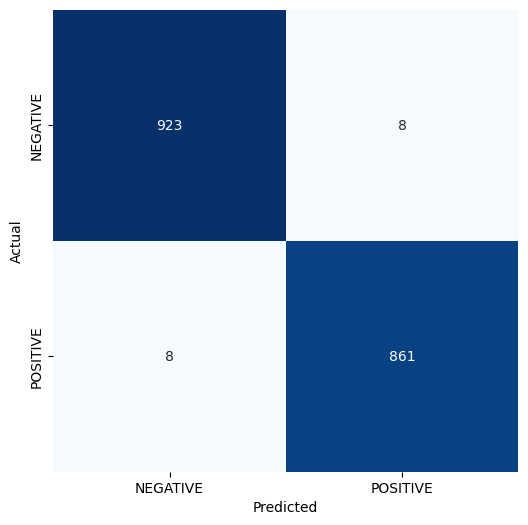

Classification Report:
------------------------------
               precision    recall  f1-score   support

    NEGATIVE       0.99      0.99      0.99       931
    POSITIVE       0.99      0.99      0.99       869

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



In [27]:
evaluate_model(model)

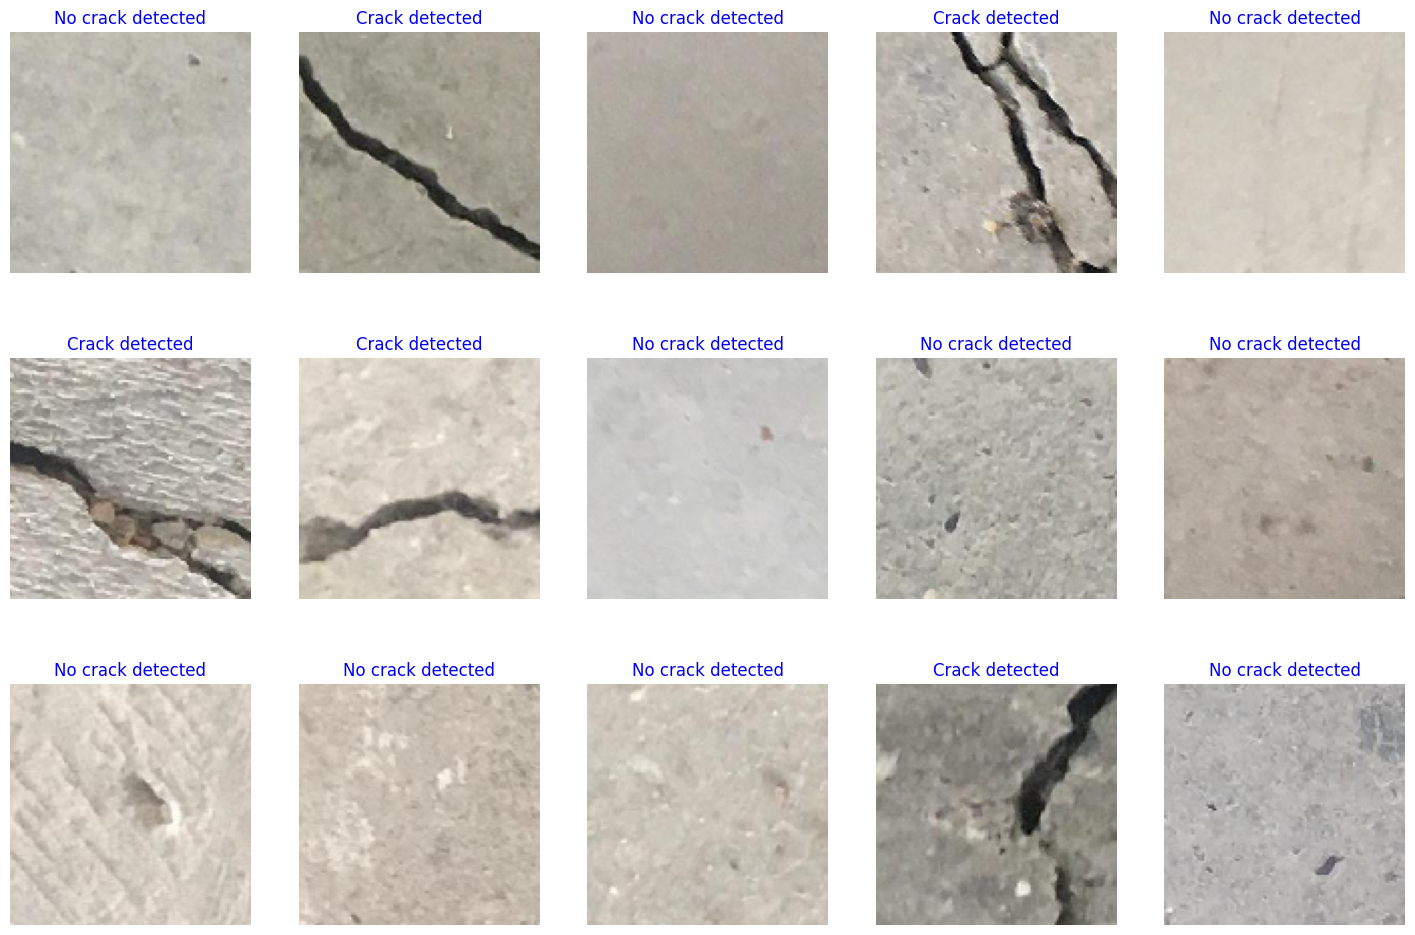

In [28]:
plt.figure(figsize=(18, 12))

for i in range(15):
    
    plt.subplot(3, 5, i+1)
    plt.imshow(test_images[0][0][i])
    plt.title("No crack detected" if y_pred[i] == 0 else "Crack detected",
              color='blue' if y_pred[i] == test_images.labels[i] else 'red')
    plt.axis('off')
    
plt.show()

MISTAKES

In [29]:
mistake_idx = (y_pred != test_images.labels).nonzero()[0]
print(len(mistake_idx), "mistakes.")
print("Indices:", mistake_idx)

16 mistakes.
Indices: [ 411  422  450  459  493  655  899  922 1051 1201 1312 1367 1453 1462
 1697 1709]


 Display the detection mistakes

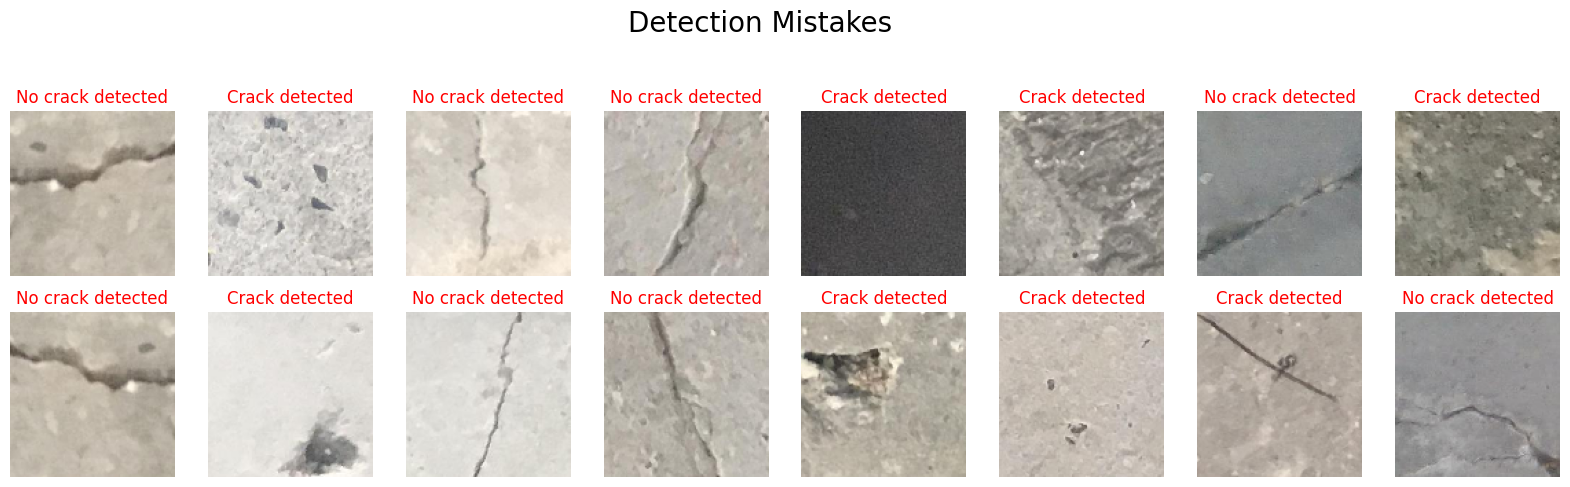

In [30]:

plt.figure(figsize=(20, 10))

for i, idx in enumerate(mistake_idx):
    
    # Get batch number and image number (batch of 32 images)
    batch = idx // 32
    image = idx % 32
    
    plt.subplot(4, 8, i+1)
    plt.imshow(test_images[batch][0][image])
    plt.title("No crack detected" if y_pred[idx] == 0 else "Crack detected", color='red')
    plt.axis('off')
    
plt.suptitle("Detection Mistakes", fontsize=20)
plt.show()

Among the 1800 images of the test set, only a few were misclassified.

Not all the images from the dataset have been used.

Results can be even better by devoting more time for training.